Module Code: CSMAD21

Assignment Report Title: Applied Data Science with Python Coursework

Student Number: 30824992

Date: 08/01/2023

Actual hours spent on assignment: 54

Assignment evaluation (3 key points): 
1. Wish had more lectures with networks, found that section tough
2. Task 1 was enjoyable but slightly daunting having complete freedom!
3. Would be fun to learn more about feature engineering that could be applied here

**Start by importing pakages that will be used in all three tasks**

In [18]:
#For use in all 3 tasks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#For use in EDA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#For use in clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from clustering_utils import plot_kmeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA #(https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
from clustering_utils import generate_2d_gmm


#For use in networks
import networkx as nx
import scipy.stats

In [4]:
import warnings

warnings.filterwarnings('ignore')

## Task 1 - Bicycle Journeys: Exploratory Data Analysis

Using pandas read_csv, the dataset is read into a dataframe. The data types that pandas has chosen are then discovered using dtypes

Some of the columns are the wrong data type so they are changed accordingly
* the start/end time columns are changed to datetime
* the start/end station columns are changed to object

In [5]:
df_metro = pd.read_csv('metro.csv')
df_metro.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,124657107,5,07/01/2019 00:04,07/01/2019 00:09,4312,34.066990,-118.290878,4410,34.063351,-118.296799,6168,30,One Way,Monthly Pass,standard
1,124657587,9,07/01/2019 00:07,07/01/2019 00:16,3066,34.063389,-118.236160,3066,34.063389,-118.236160,17584,30,Round Trip,Monthly Pass,electric
2,124658068,5,07/01/2019 00:20,07/01/2019 00:25,4410,34.063351,-118.296799,4312,34.066990,-118.290878,18920,30,One Way,Monthly Pass,electric
3,124659747,20,07/01/2019 00:44,07/01/2019 01:04,3045,34.028511,-118.256668,4275,34.012520,-118.285896,6016,1,One Way,Walk-up,standard
4,124660227,27,07/01/2019 00:44,07/01/2019 01:11,3035,34.048401,-118.260948,3049,34.056969,-118.253593,5867,30,One Way,Monthly Pass,standard


In [6]:
df_metro.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration            int64
trip_route_category     object
passholder_type         object
bike_type               object
dtype: object

In [7]:
df_metro['start_time'] = pd.to_datetime(df_metro['start_time'])
df_metro['end_time'] = pd.to_datetime(df_metro['end_time'])

df_metro['start_station'] = df_metro['start_station'].astype(object)
df_metro['end_station'] = df_metro['end_station'].astype(object)

To see summary statistics of the dataset before preprocessing, the describe function is used. 

To see the shape of the dataframe, shape is used.

There are 92124 samples and 15 features.

Some interesting initial findings are:
* the start_lat/lon and end_lat/lon columns have less rows than the other rows 
* the start_station and end_station means are different, inferring that people end their trips in different stations than where they start, on average

* the maximum trip length is 999 minutes which is 16.65 hours - could be an anomonly 
    * seems even more likely to be anomaly as 75% of the data is less than half an hour
* The minimum trip length is 1 minute, as well as 25% of the data, which also seems incorrect
    * This could be due to customers quickly putting their bike back as soon as they got, or technical errors

In [6]:
print(df_metro.shape)
df_metro.describe()

(92124, 15)


,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration
count,9.212400e+04,92124.000000,89985.000000,89985.000000,88052.000000,88052.000000,92124.000000
mean,1.274286e+08,33.168588,34.034786,-118.287893,34.034895,-118.286699,60.290977
std,1.524134e+06,129.057841,0.058803,0.073501,0.058790,0.072628,111.141364
min,1.246571e+08,1.000000,33.710979,-118.495422,33.710979,-118.495422,1.000000
25%,1.261375e+08,6.000000,34.035801,-118.281181,34.037048,-118.280952,1.000000
50%,1.274911e+08,12.000000,34.046810,-118.258537,34.046810,-118.258537,30.000000
75%,1.287379e+08,22.000000,34.051941,-118.248253,34.051941,-118.248253,30.000000
max,1.303877e+08,1440.000000,34.177662,-118.231277,34.177662,-118.231277,999.000000


Trip_id isn't useful for analysis so the column is dropped

In [7]:
df_metro = df_metro.drop('trip_id', axis=1)

Next, I want to find out whether the dataset has duplicate rows and/or missing values.

We discover that there are no duplicates, however there are missing values in the start_lat/lon and end_lat/lon columns which explains the lower number of counts from above.

In [8]:
df_metro.duplicated().sum()

0

In [8]:
df_metro.isnull().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station             0
start_lat              2139
start_lon              2139
end_station               0
end_lat                4072
end_lon                4072
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
bike_type                 0
dtype: int64

There are a few thousand missing values. To deal with them I opted to fill in the values with the mode. 
* I didn't want to delete the rows because I want the most data I can get, but I didn't want to fill in with mean as the columns with missing values represent locations so I felt using the mode to fill in these was a good representation of an actual location

In [9]:
df_metro['start_lat'].fillna(df_metro['start_lat'].mode()[0], inplace=True)
df_metro['start_lon'].fillna(df_metro['start_lon'].mode()[0], inplace=True)
df_metro['end_lat'].fillna(df_metro['end_lat'].mode()[0], inplace=True)
df_metro['end_lon'].fillna(df_metro['end_lon'].mode()[0], inplace=True)

Next, I look to see what the unique values in columns with categories are and use bar charts to visualise the counts of these categories easily.

In [11]:
trips = df_metro['trip_route_category'].unique()
passholders = df_metro['passholder_type'].unique()
bikes = df_metro['bike_type'].unique()

print(f'Trip route type: {trips}')   
print(f'Passholder types: {passholders}')  
print(f'Bike types: {bikes}')      

Trip route type: ['One Way' 'Round Trip']
Passholder types: ['Monthly Pass' 'Walk-up' 'Annual Pass' 'One Day Pass' 'Flex Pass'
 'Testing']
Bike types: ['standard' 'electric' 'smart']


There are 2 trip routes - one way or round trip - and they have a large class imbalance. The one way trip has 76.7K entries, whereas a round trip only has 15.3k entries.

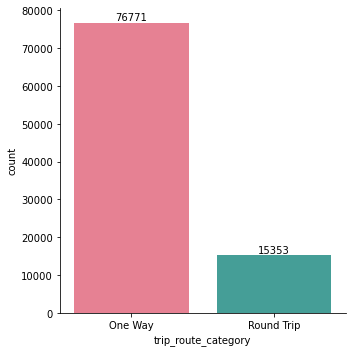

<Figure size 720x504 with 0 Axes>

In [12]:
trip_plot = sns.catplot(data= df_metro, x= 'trip_route_category', kind='count', palette="husl");
plt.figure(figsize=(10, 7))

for ax in trip_plot.axes.ravel():
    for n in ax.containers:
        labels = [f'{(v.get_height()):.0f}' for v in n]
        ax.bar_label(n, labels=labels, label_type='edge')

plt.show();

There are 6 types of passholders, the most popular one being the monthly pass with 57.1k, which is followed by walk-up passes at 23.5k.
The smallest category of passholders is the flex pass which has only 6 trips.

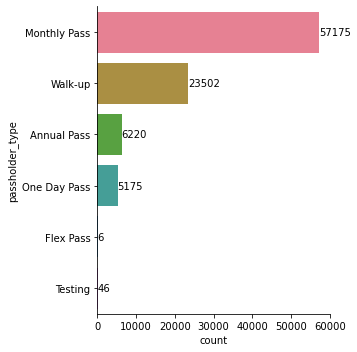

<Figure size 1080x504 with 0 Axes>

In [13]:
pass_plot = sns.catplot(data=df_metro, y='passholder_type', kind='count', palette="husl");
plt.figure(figsize=(15, 7))

for ax in pass_plot.axes.ravel():
    for n in ax.containers:
        labels = [f'{(v.get_width()):.0f}' for v in n]
        ax.bar_label(n, labels=labels)

plt.show()

The majority of bikes were electric (50.42%), followed by standard bikes with just under a third of trips, and finally smart bikes accounted for 17.59% of the trips.
The bike types are imbalanced as a result.

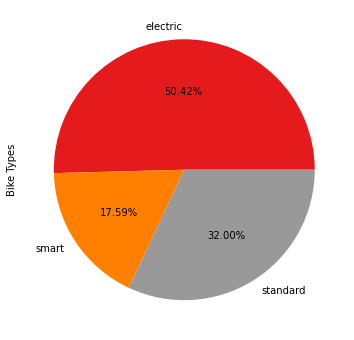

In [14]:
df_metro.groupby('bike_type').size().plot(kind='pie', autopct = lambda a:f'{a:.2f}%', ylabel="Bike Types", colormap="Set1", figsize=(6,6));

Now we find the mean duration of each passholder type in minutes.

The highest mean was for a one day pass which shows the average trip was 79 minutes.
The lowest mean was for flex pass which shows the average trip as 7 minutes.

This is probably because if you are paying for one day you want to make the most of the bike and are probably paying for a specific trip, but with a flex pass it implies a more flexible approach so you most likely paid for the bike for more than a day and don't have that level of committment as with a day pass.

In [15]:
df_metro.groupby(['passholder_type'])['duration'].mean()

passholder_type
Annual Pass     15.664148
Flex Pass        7.333333
Monthly Pass    15.854919
One Day Pass    79.548599
Testing         29.608696
Walk-up         69.722449
Name: duration, dtype: float64

Using crosstab, a table of passholder type by bike type was created, and subsequently used to create a barplot
* From the barplot we can see that most monthly passes come from people with electric bikes
* smart bikes have barely any annual pass holders, but the most one day passes
* standard bikes seems to have the most walk-up passes

In [16]:
pd.crosstab(df_metro['bike_type'], df_metro['passholder_type'])    #find counts of crosstabulation of bike type and passholder type

passholder_type,Annual Pass,Flex Pass,Monthly Pass,One Day Pass,Testing,Walk-up
bike_type,,,,,,
electric,3467,2,35556,1047,0,6374
smart,278,0,4656,3165,46,8056
standard,2475,4,16963,963,0,9072


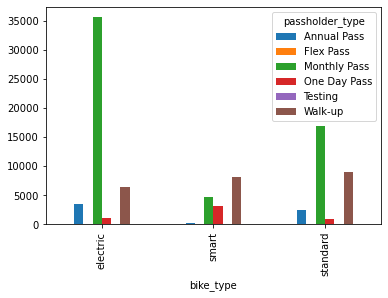

In [17]:
pd.crosstab(df_metro['bike_type'], df_metro['passholder_type']).plot.bar();

**Determining the shortest and longest trips and when they occur:**
* The longest trip being 1440 minutes seems like an outlier
* We can see this more clearly by plotting a histogram and see there are no trips near the 1440 trip
* The data is very positively skewed

In [18]:
low_dur = df_metro.duration.idxmin()
high_dur = df_metro.duration.idxmax()
low_anom = df_metro.duration.min()
high_anom = df_metro.duration.max()

print(f'The shortest trip duration is on {low_dur} with {low_anom} minutes, and the longest trip is on {high_dur} with {high_anom} minutes')

The shortest trip duration is on 83 with 1 minutes, and the longest trip is on 126 with 1440 minutes


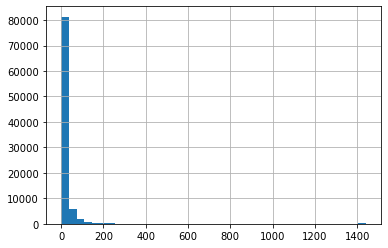

In [19]:
df_metro.duration.hist(bins=40);

I remove the rows where the duration is over 200, an estimate based off the barplot made
* this leaves us with all the trips less than 200 minutes (just over 3 hours)
* I chose 200 minutes after testing 600, 400 and 300 minutes and found the distributions were still extremely skewed
* I didn't want to go much below 200 minutes so not much data was lost and i thought some people may still have a trip for around 3 hours
* the graph is still very skewed but has more of a shape than previously

In [10]:
df_metro = df_metro[df_metro.duration < 200]

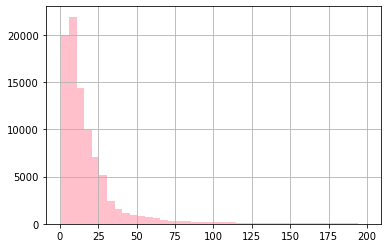

In [21]:
df_metro.duration.hist(color="pink", bins=40);

Looking at the distributions of the passholder types a few things stand out:
* Flex pass only has trips towards the 0 mark
* Testing pass is positively skewed but has what looks like an outlier near the 150 mark
* Walk-up trips look pretty evenly spread with a bit less density towards the 200 mark
     * This is similar for monthly pass and one day pass too
* The annual pass has a lot of samples where the duration is below around 20 minutes, then is scattered up to the 200 mark

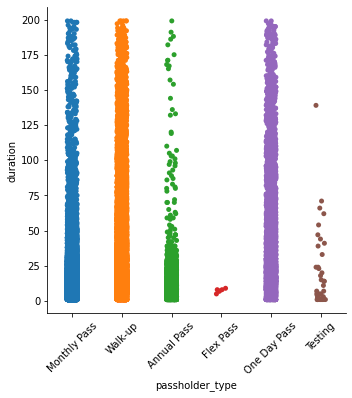

In [22]:
sns.catplot(x= 'passholder_type', y='duration', data=df_metro)
plt.xticks(rotation=45);

Next, we will look at how the duration of a journey changes betwen one way trips and round trips

We start by encoding the two categories, a one way trip becomes 0, and a round trip becomes 1

In [23]:
label = LabelEncoder()
df_metro['trip_route_category_enc'] = label.fit_transform(df_metro['trip_route_category'])
df_metro[['trip_route_category', 'trip_route_category_enc']]

,trip_route_category,trip_route_category_enc
0,One Way,0
1,Round Trip,1
2,One Way,0
3,One Way,0
4,One Way,0
...,...,...
92119,One Way,0
92120,Round Trip,1
92121,One Way,0
92122,One Way,0


Next, a kde plot is made showing the distribution of both kinds of trips against each other

* We see that one way trips has a lower standard deviation (less spread out) and round trips are slightly more spread out 
* Round trips peaks slightly sooner than one way trips at around 0, but then has a second lower peak at around 25 minutes.

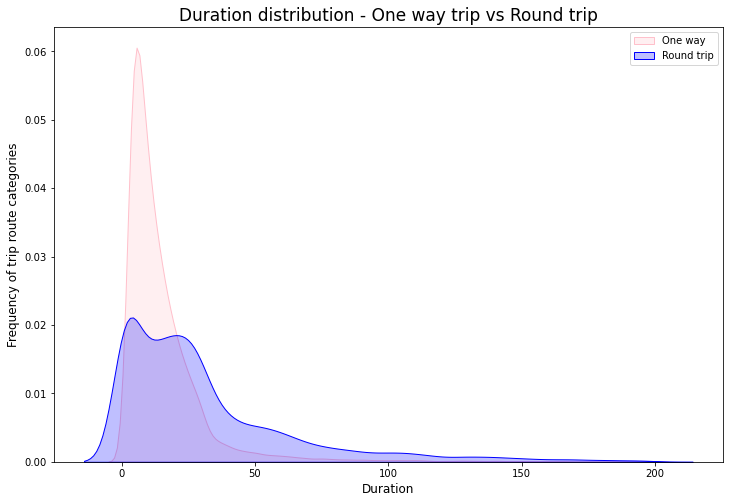

In [26]:
fig = plt.figure(figsize=(12, 8))
ax = sns.kdeplot(df_metro.loc[(df_metro['trip_route_category_enc'] == 0), 'duration'],
                 color='pink', shade=True, label='One way')
ax = sns.kdeplot(df_metro.loc[(df_metro['trip_route_category_enc'] == 1), 'duration'],
                 color='blue', shade=True, label='Round trip')
plt.title('Duration distribution - One way trip vs Round trip', fontsize=17)
plt.ylabel('Frequency of trip route categories', fontsize=12)
plt.xlabel('Duration', fontsize=12)
plt.legend();

Now we will look at some time series analysis.
* To start, I split the time column into year, month, day of week and hour and append each to the end of the dataframe

In [27]:
df_metro['year'] = df_metro['start_time'].dt.year
df_metro['month'] = df_metro['start_time'].dt.month
df_metro['day'] = df_metro['start_time'].dt.day
df_metro['day_of_week'] = df_metro['start_time'].dt.dayofweek
df_metro['hour'] = df_metro['start_time'].dt.hour

By grouping the number of rides by the day of the week they start on we see that Saturdays have the least number of rides and Tuesday have the most number of rides

In [28]:
df_metro.groupby(['day_of_week']).agg(number_of_rides=('trip_route_category', 'count'))

,number_of_rides
day_of_week,
0,13698
1,14077
2,13374
3,13667
4,13578
5,10896
6,11102


<AxesSubplot:xlabel='day_of_week'>

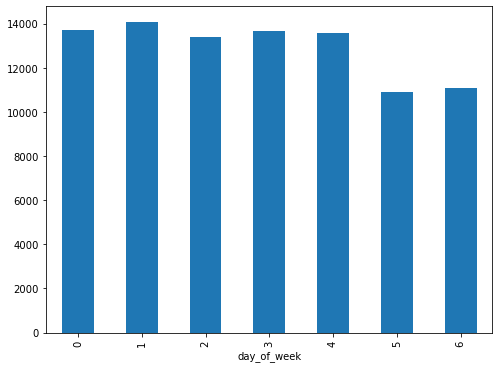

In [29]:
df_metro.groupby(['day_of_week'])['duration'].count().plot.bar(figsize = (8, 6))

In a similar way we can look at the number of trips but using their starting hour instead

We see that, as you would expect, there are very few trips at night especially between 1 and 5 am, and most trips start in the 17th hour which makes sense as people will probably use the bikes to go home after work.

<AxesSubplot:xlabel='hour'>

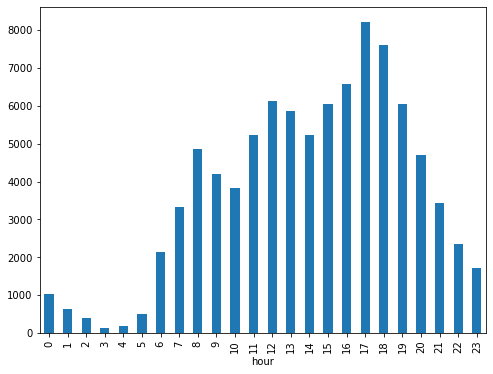

In [30]:
df_metro.groupby(['hour'])['duration'].count().plot.bar(figsize = (8, 6))

The below histogram shows us that there is an increase in bike rides up until around the third week of august (which is peak of summer so makes sense as more people will be out in the sun), then there appears to be a steady decrease in rides from there but would need a longer period of data to see if this relationship with the seasons is true.

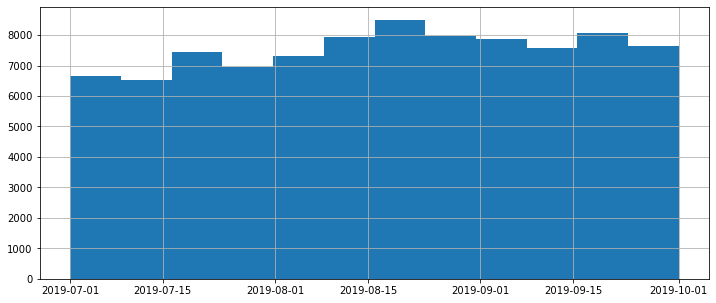

In [32]:
df_metro['start_time'].hist(figsize=(12,5), bins=12);

Next, I want to look at the distance travelled for the trips
* to find the distance between two geo coordinates, the haversine distance formula will need to be used (https://en.wikipedia.org/wiki/Haversine_formula)
* I opt for a formula that calculates row by row of a dataframe (idea from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas)
* I will use an estimate for the radius of earth at 6378 km (https://imagine.gsfc.nasa.gov/features/cosmic/earth_info.html)

In [13]:
def haversine_distance(geo):
    dlon = np.radians(geo[2]) - np.radians(geo[0])
    dlat = np.radians(geo[3]) - np.radians(geo[1]) 
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(geo[1])) * np.cos(np.radians(geo[3])) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6378 * c

In [14]:
df_metro['distance'] = df_metro[['start_lon', 'start_lat', 'end_lon', 'end_lat']].apply(haversine_distance, axis=1)

If we plot distance against duration the resultant graphs gradient will show the speed. Average speed seems to be around 1km/5mins (very rough estimate taken off graph)

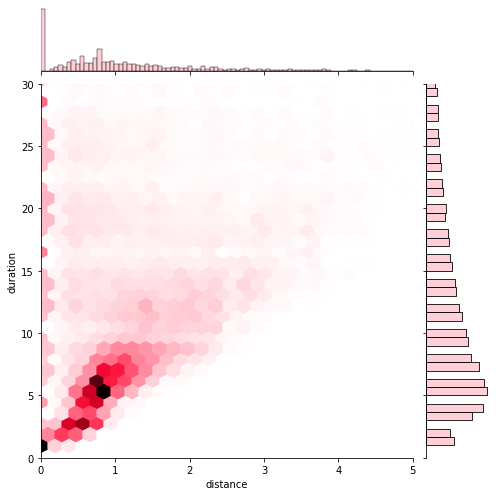

In [15]:
sns.jointplot(x=df_metro['distance'],
              y=df_metro['duration'], kind='hex', size = 7, color='pink', 
              joint_kws=dict(gridsize=200), xlim=(0, 5), ylim=(0, 30));

The summary statistics of the distance show us that the maximum journey lenght was 37.6km, and the mean is 1.8km. This is inline with the statistics of the duration of journeys where most were very short but few journeys were long. It has the same skew.

In [36]:
df_metro['distance'].describe()

count    90392.000000
mean         1.852998
std          3.732385
min          0.000000
25%          0.445607
50%          0.900228
75%          1.751646
max         37.649388
Name: distance, dtype: float64

## Task 2 – Seed Shapes: Data Clustering

In [37]:
df_seeds = pd.read_csv('seeds.csv')
df_seeds.head()

,area,perimeter,compactness,length,width,asymmetry,groove_length
0,15.26,14.84,0.871,5.763,3.312,2.221,5.220
1,14.88,14.57,0.881,5.554,3.333,1.018,4.956
2,14.29,14.09,0.905,5.291,3.337,2.699,4.825
3,13.84,13.94,0.895,5.324,3.379,2.259,4.805
4,16.14,14.99,0.903,5.658,3.562,1.355,5.175


In [38]:
print(df_seeds.shape)
df_seeds.describe()

(210, 7)


,area,perimeter,compactness,length,width,asymmetry,groove_length
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.871000,5.628533,3.258605,3.700200,5.408071
std,2.909699,1.305959,0.023594,0.443063,0.377714,1.503559,0.491480
min,10.590000,12.410000,0.808000,4.899000,2.630000,0.765000,4.519000
25%,12.270000,13.450000,0.857250,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873500,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887750,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918000,6.675000,4.033000,8.456000,6.550000


Using a pairplot we can see a scatter matrix of all the features:
* area-area: slightly positively skewed
* area-perimeter: strong positive correlation
* area-compactness: maybe a slight positive correlation
* area-length: a moderately strong positive correlation
* area-width: a moderately strong positive correlation
* area-asymmetry: seems to be pretty uncorrelated
* area-groove length: a moderate positive correlation
* perimeter-perimeter: a spread out distribution
* perimeter-compactness: maybe a slight positive correlation
* perimeter-length: strong positive correlation
* perimeter-width: a moderately strong positive correlation
* perimeter-asymmetry: seems to have no correlation
* perimeter-groove length:a moderate positive correlation
* compactness-compactness: a slight negative skewed distribution
* compactness-length: looks like no correlation
* compactness-width: a moderate positive correlation
* compactness-asymmetry: looks like no correlation
* compactness-groove length: looks like no correlation
* length-length: positve skew
* length-width: moderately strong positive correlation
* length-asymmetry: looks like no correlation
* length-groove length: strong positive correlation
* width-width: looks like an almost uniform distribution but slightyl tapers off at the end
* width-asymmetry: looks like no correlation
* width-groove length: a moderate positive correlation
* asymmetry-asymmetry: very slight positive skew
* asymmetry-groove length: looks like no correlation
* groove length-groove length: a slight positive skew

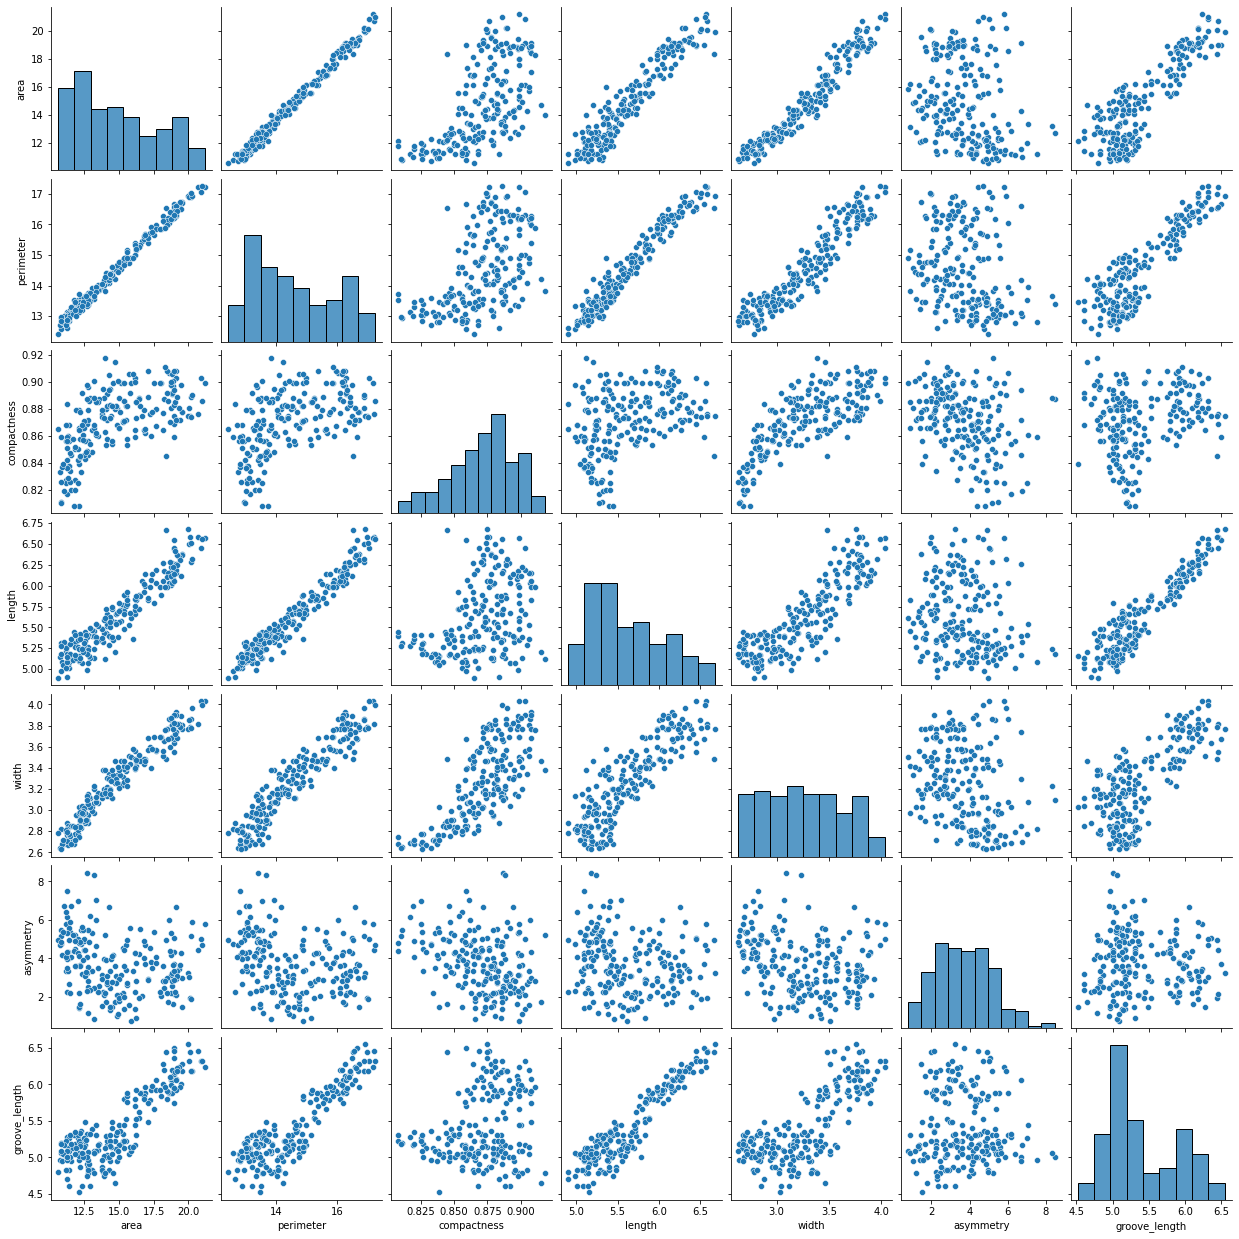

In [39]:
sns.pairplot(df_seeds);

By looking at a heatmap of the correlations we see that **most** of the features have moderate to strong positive correlation with each other, except for the asymmetry feature which is negatively correlated with every feature

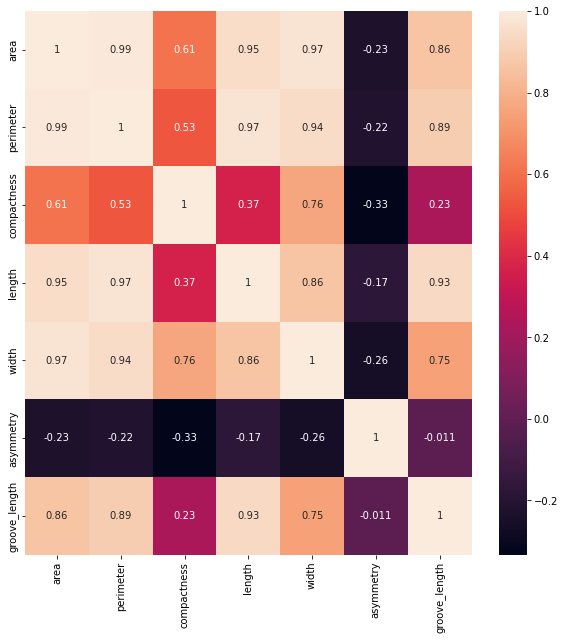

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(df_seeds.corr(), annot=True);

By using info() we see there are no missing values in the dataset

Also, by looking at the sum of dulicate samples we see there are 0

In [41]:
df_seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           210 non-null    float64
 1   perimeter      210 non-null    float64
 2   compactness    210 non-null    float64
 3   length         210 non-null    float64
 4   width          210 non-null    float64
 5   asymmetry      210 non-null    float64
 6   groove_length  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [42]:
df_seeds.duplicated().sum()

0

**K-means clustering**

First, to use K-means clustering the data should to be normalised.

It returns an the data as arrays that have means of 0 and standard deviations of 1.

In [43]:
scaler = StandardScaler()
scaled_seeds = scaler.fit_transform(df_seeds)

In [44]:
scaled_seeds

array([[ 0.14209777,  0.21546244,  0.        , ...,  0.14170182,
        -0.9861499 , -0.38357742],
       [ 0.01118803,  0.00822376,  0.42484468, ...,  0.19743223,
        -1.78816338, -0.92201349],
       [-0.19206658, -0.36020056,  1.44447192, ...,  0.20804754,
        -0.66747788, -1.18919199],
       ...,
       [-0.56757084, -0.69024735,  0.72223596, ..., -0.07060448,
         3.07658503, -0.71806043],
       [-1.03608992, -1.03564515, -0.8072049 , ..., -1.12152071,
        -0.06813448, -0.7425348 ],
       [-0.87762023, -0.93586356, -0.1274534 , ..., -0.75529233,
         1.2912217 , -0.70378372]])

Next, we will use the elbow method to find the optimal number of clusters. Inertia against k number of clusters is plotted and the point at which inertia stops descreasing linearly is chosen as the optimal number of clusters.

The inertia is the sum of squared distances of samples to their closest cluster center.

We see that the elbow point is at k=3, so the optimal number of clusters we will use is 3.

In [53]:
clusters = []

for k in range (1, 12):
    km = KMeans(n_clusters=k, n_init=12, random_state=300)
    km = km.fit(scaled_seeds)
    clusters.append(km.inertia_)

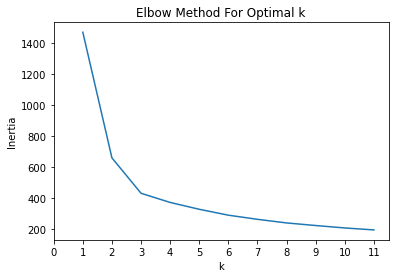

In [54]:
plt.plot(range(1, 12), clusters)
plt.xticks(np.arange(0, 12, step=1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k');

Next we will make a model using out number of clusters as 3, and fit the data to it.

In [55]:
k_means = KMeans(n_clusters= 3, n_init= 30, random_state=42)

k_means.fit(scaled_seeds)

y_pred = k_means.predict(scaled_seeds)

Looking at what the predictions looks like they are nearly evenly spready between the 3 clusters

Cluster 1 has the most samples are cluster 0 has the least (but only 5 less than cluster 1)

In [56]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
np.array(np.unique(y_pred, return_counts=True)).T

array([[ 0, 67],
       [ 1, 72],
       [ 2, 71]], dtype=int64)

The coordinates of the cluster centers that the model predicted are as below.

Cluster 1 has 6 of 7 negative dimensions, whereas cluster 0 only has 1 negative dimension. Cluster 2 has 5 negative dimensions for the cluster center

In [58]:
k_means.cluster_centers_

array([[ 1.25668163,  1.26196622,  0.56117544,  1.23788278,  1.16485187,
        -0.04521867,  1.29230787],
       [-1.03025257, -1.00664879, -0.96534153, -0.89768501, -1.08558344,
         0.69480427, -0.62480856],
       [-0.14111949, -0.17004259,  0.44937797, -0.25781445,  0.00164694,
        -0.6619191 , -0.58589311]])

**PCA**

Principle component analysis (PCA) can be used to reduce the number of features, making it easier to visualise the clusters we get from k-means clustering.

We will reduce the dimensions to 2 so we can plot on a 2d graph.

The predicted cluster label for each sample will remain the same.

In [60]:
pca = PCA(n_components=2).fit_transform(scaled_seeds)

In [61]:
pca_df = pd.DataFrame(pca, columns=['pca1','pca2'])
pca_df['label'] = y_pred
pca_df

,pca1,pca2,label
0,0.317078,0.783940,2
1,-0.004093,1.911672,2
2,-0.458216,1.907800,2
3,-0.596876,1.920389,2
4,1.099266,2.059811,2
...,...,...,...
205,-1.994188,0.859613,1
206,-2.728452,-0.210375,1
207,-1.406693,-1.306413,1
208,-2.340885,0.097664,1


We will also perform PCA on the cluster centers so we can plot them on the same graph.

In [62]:
pca_cent = PCA(n_components=2).fit_transform(k_means.cluster_centers_)

By reducing the data we can now visualise the clusters.

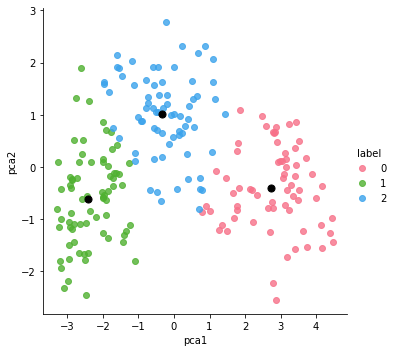

In [63]:
sns.lmplot( x='pca1', y='pca2', data=pca_df, fit_reg=False, hue='label', legend=True, palette='husl')
# Model cluster centers
plt.scatter(pca_cent[:, 0], pca_cent[:, 1], c='black', marker='o', s=50);

**Gaussian Mixture Models (GMM)**

We will use GMM instead of DBScan here since it is considered an extension on k-means so it will be interesting to compare the results of them.

The features do not need to be normalised for GMM so we will use df_seeds instead of scaled_seeds

To find the optimal number of components to use we will look at AIC and BIC scores
* both AIC and BIC scores stop linearly decreasing at n=4 components

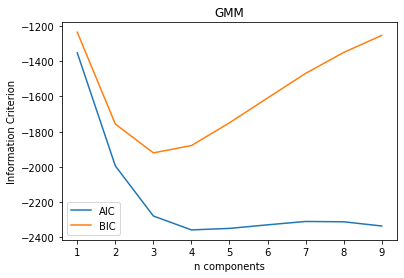

In [66]:
n_components = range(1, 10)

models = [GMM(n, covariance_type='full', random_state=0).fit(df_seeds)
          for n in n_components]

plt.plot(n_components, [m.aic(df_seeds)
         for m in models], label='AIC')
plt.plot(n_components, [m.bic(df_seeds)
         for m in models], label='BIC')
plt.title('GMM')
plt.ylabel('Information Criterion')
plt.xlabel('n components')
plt.legend();

Again, since we have more dimensions than we can plot we will use PCA to reduce the dimenions to 2 so we can visualise the clusters.

In [67]:
pca2 = PCA(n_components=2).fit_transform(df_seeds)

In [68]:
pca2_df = pd.DataFrame(pca2, columns=['pca1','pca2'])
pca2_df

,pca1,pca2
0,0.663448,-1.417320
1,0.315666,-2.689228
2,-0.660499,-1.131506
3,-1.055278,-1.621188
4,1.619997,-2.183382
...,...,...
205,-3.041874,-0.473125
206,-4.109063,0.109342
207,-2.500036,4.307966
208,-3.332079,-0.525289


Next, we will fit the model with the seeds data, using the 4 components.

In [69]:
gmm_seeds = GMM(n_components=4, n_init=20, random_state=42)
gmm_seeds.fit(pca2_df)
y_gmm_seeds = gmm_seeds.predict(pca2_df)

In [70]:
pca2_df['label'] = y_gmm_seeds

Cluster 3 only has 3 samples but the other 3 clusters look like they have a similar spread to the kmeans clusters
* The largest cluster (1) has 75 samples
* This is followed by label 2 with 68 samples
* Then label 0 with 49
* Finally cluster 3 has 18 samples

In [71]:
np.array(np.unique(y_gmm_seeds, return_counts=True)).T

array([[ 0, 36],
       [ 1, 78],
       [ 2, 72],
       [ 3, 24]], dtype=int64)

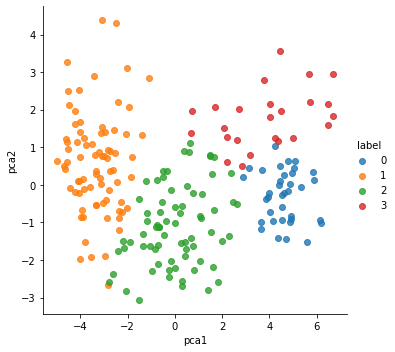

In [72]:
sns.lmplot( x='pca1', y='pca2', data=pca2_df, fit_reg=False, hue='label', legend=True);

Using generate_2d_gmm we can see the contour lines to see more in depth how the gmm model has decided to cluster the data.

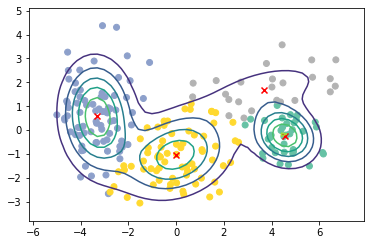

In [73]:
generate_2d_gmm(gmm_seeds, pca2)

**Comparison**

Finally, we will compare k means to GMM for the different number of clusters on the same normalised pca data 

It looks like kmeans tends to distribute samples among the clusters more evenly than gmm.

The biggest difference can be seen in n=4 clusters.

In [74]:
pca_comp = pd.DataFrame(pca, columns=['pca1','pca2'])

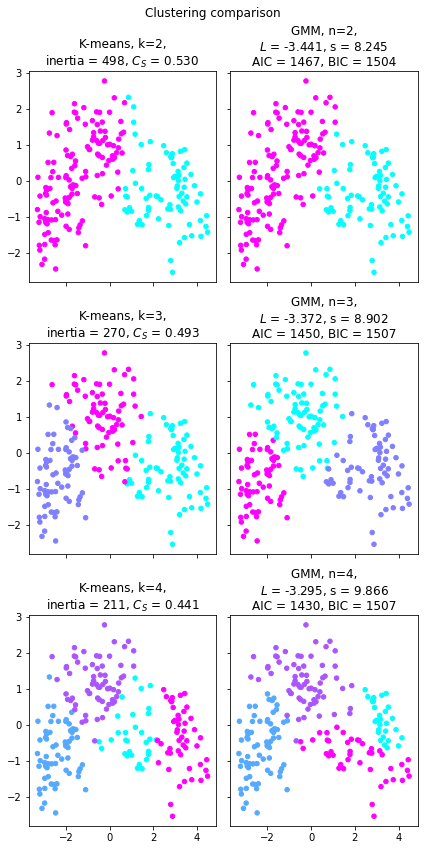

In [75]:
fig, ax = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(6, 12))
fig.suptitle('Clustering comparison')

c_num = np.arange(2, 5)

for n in c_num:
    inst = n - c_num[0]
    km_seeds = KMeans(n_clusters=n, n_init=20, random_state=42)
    gmm_seeds = GMM(n_components=n, n_init=20, random_state=42)

    km_seeds.fit(pca_comp)
    gmm_seeds.fit(pca_comp)

    y_km = km_seeds.predict(pca_comp)
    y_gmm = gmm_seeds.predict(pca_comp)

    ax[inst][0].scatter(x='pca1', y='pca2', data=pca_comp, c=y_km, s=20, cmap='cool')
    ax[inst][0].set_title(
        f'K-means, k={n},\n'
        f'inertia = {km_seeds.inertia_:.0f}, $C_S$ = {silhouette_score(pca_comp, km_seeds.labels_):.3f}')
    silhouette_score(pca_comp, km_seeds.labels_)
    ax[inst][1].scatter(x='pca1', y='pca2', data=pca_comp,
                        c=y_gmm, s=20, cmap='cool')
    ax[inst][1].set_title(
        f'GMM, n={n},\n'
        f'$L$ = {gmm_seeds.score(pca_comp):.3f}, s = {np.exp(gmm_seeds.score_samples(pca_comp)).sum():.3f}'
        f'\nAIC = {gmm_seeds.aic(pca_comp):.0f}, BIC = {gmm_seeds.bic(pca_comp):.0f}')
    
plt.tight_layout()

I believe the soft partitions of GMM is more suited to cluster data in most cases, from a glance the clusters for gmm in direct comparison to kmeans look like they make more sense, probably due to the fact it is based on probability rather than distance.

## Task 3 – Social Networks: Network Analysis

To start, the file is imported as a dataframe so I can see what it looks like and what we are dealing with, noticing the top row was not a header so used the header=None parameter

In [19]:
df_sn = pd.read_csv('social-network.csv', header=None)
df_sn

,0,1
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
2976,2699,2884
2977,2699,2885
2978,2699,2886
2979,2699,2887


The read_adjlist function from networkx was used to read the file and separate the nodes by a comma, it is now in the edge list format

In [20]:
g = nx.read_adjlist('social-network.csv', delimiter = ',')

Looking at some basic stats of the network we see there are:
* 2888 nodes
* 2981 edges  (so there are nodes with more than 1 connection)
* the largest number of degrees a node has is 769
* the smallest number of degrees a node has is 1
* the average number of degrees a node has is 2.06 (since the maximum is 769 this implies there is a heavy skew)
* the diamater is 9

In [78]:
g.number_of_nodes(), g.number_of_edges()

(2888, 2981)

In [79]:
degrees = []

for n in g.nodes():
    degrees.append(nx.degree(g,n))

In [80]:
print(max(degrees))
print(min(degrees))

769
1


In [81]:
sum(degrees)/len(degrees)

2.064404432132964

In [82]:
nx.number_connected_components(g)

1

In [83]:
nx.diameter(g)

9

Using spring layout, the network is visualised
* There appears to be lots of hubs 
* There are 3 big hubs in particular

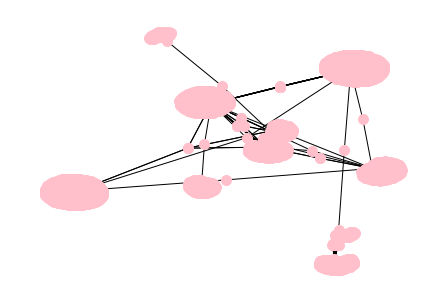

In [84]:
layout = nx.spring_layout(g)
nx.draw(g, pos=layout, node_size=100, node_color='pink')

**Degree distribution**

Degree distribution is a probability distribution of the number of connections nodes have to other nodes in the network.

The degree distribution of this network is very positively skewed with a long tail.

A simple bar plot doesn't capture much information as so many of the nodes have a low number of connections, making it impossible to see the few nodes with high numbers of connections.

This meant a loglog scale was more appropriate to use.

It shows more clearly how long the tail is and how skewed the distribution is.

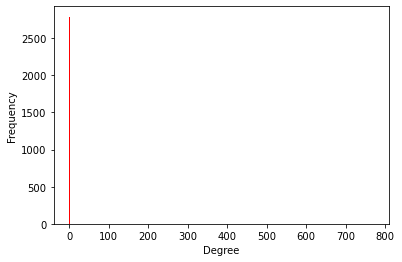

In [88]:
plt.bar(range(0,len(nx.degree_histogram(g))),nx.degree_histogram(g), color='red')
plt.xlabel("Degree")
plt.ylabel("Frequency");

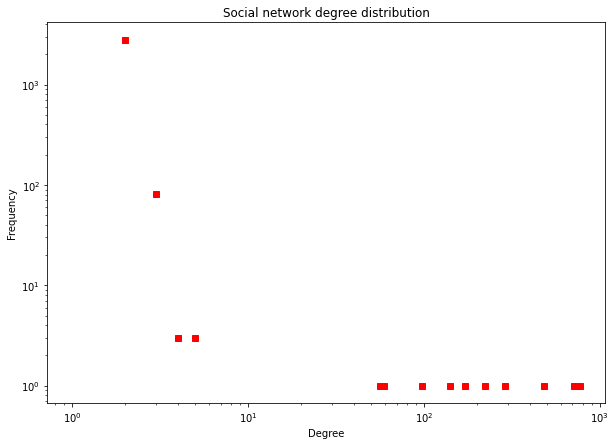

In [89]:
deg_dist = nx.degree_histogram(g)

plt.figure(figsize=(10, 7))
plt.loglog(range(1,len(deg_dist)+1), deg_dist, 's', color='red')
plt.title('Social network degree distribution')
plt.ylabel('Frequency')
plt.xlabel('Degree');

**Cluster coefficient**

The cluster coefficient shows how nodes tend to cluster together. It measures the number of triangles in the graph.(https://www.geeksforgeeks.org/clustering-coefficient-graph-theory/)

Many of the cluster coefficents are around 0 suggesting most of the graph does not tend to cluster together, but the histogram shows some coefficents of near 1, meaning a small fraction of the graph is strongly clustered together.

The histogram doesn't capture other coefficents very well, for example looking at the output of clust_c, node 247 has a cluster coefficent of 0.33 but it's probable that so few cluster coefficents are between 0.1 and 0.9 that they are outnumbered.

In [21]:
clust_c = nx.clustering(g)
clust_c

{'1': 2.436587802441461e-05,
 '2': 0,
 '3': 0,
 '4': 0,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0,
 '10': 0,
 '11': 0,
 '12': 0,
 '13': 0,
 '14': 0,
 '15': 0,
 '16': 0,
 '17': 0,
 '18': 0,
 '19': 0,
 '20': 0,
 '21': 0,
 '22': 0,
 '23': 0,
 '24': 0,
 '25': 0,
 '26': 0,
 '27': 0,
 '28': 0,
 '29': 0,
 '30': 0,
 '31': 0,
 '32': 0,
 '33': 0,
 '34': 0,
 '35': 0,
 '36': 0,
 '37': 0,
 '38': 0,
 '39': 0,
 '40': 0,
 '41': 0,
 '42': 0,
 '43': 0,
 '44': 0,
 '45': 0,
 '46': 0,
 '47': 0,
 '48': 0,
 '49': 0,
 '50': 0,
 '51': 0,
 '52': 0,
 '53': 0,
 '54': 0,
 '55': 0,
 '56': 0,
 '57': 0,
 '58': 0,
 '59': 0,
 '60': 0,
 '61': 0,
 '62': 0,
 '63': 0,
 '64': 0,
 '65': 0,
 '66': 0,
 '67': 0,
 '68': 0,
 '69': 0,
 '70': 0,
 '71': 0.3333333333333333,
 '72': 0,
 '73': 0,
 '74': 0,
 '75': 0,
 '76': 0,
 '77': 0,
 '78': 0,
 '79': 0,
 '80': 0,
 '81': 0,
 '82': 0,
 '83': 0,
 '84': 0,
 '85': 0,
 '86': 0,
 '87': 0,
 '88': 0,
 '89': 0,
 '90': 0,
 '91': 0,
 '92': 0,
 '93': 0,
 '94': 0,
 '95': 0,
 '96': 0,
 '97': 0,
 '

Text(0.5, 0, 'Clustering coefficient')

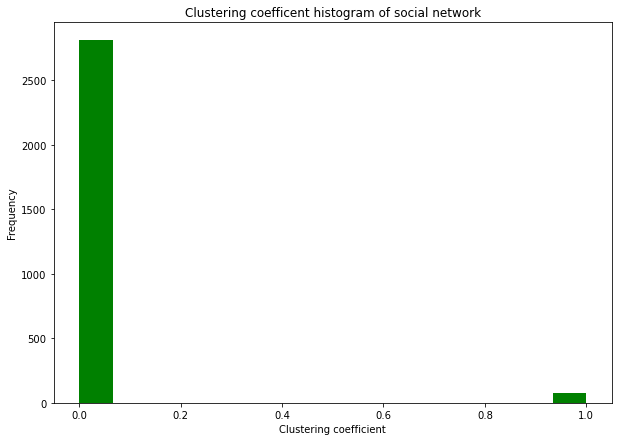

In [91]:
plt.figure(figsize=(10,7))
plt.hist(list(clust_c.values()),bins=15, color='green')
plt.title('Clustering coefficent histogram of social network')
plt.ylabel("Frequency")
plt.xlabel("Clustering coefficient")

**Betweeness centrality**

Between centrality measures the importance of a node

From sorting a dictionary of the nodes with their between centrality key we see that node 603 is the most important when looking at this statistic. It has the highest fraction of all shortest paths passing through it. It is followed by node 288 and 1525 which both have betweeness centralities above 0.42.

The betweeness centrality falls quickly after this to 0.24 for node 247.

In [24]:
bet_cen = nx.betweenness_centrality(g)
bet_cen

{'1': 0.1860965105682874,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.0,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.0,
 '19': 0.0,
 '20': 0.0,
 '21': 0.0,
 '22': 0.0,
 '23': 0.0,
 '24': 0.0,
 '25': 0.0,
 '26': 0.0,
 '27': 0.0,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.0,
 '33': 0.0,
 '34': 0.0,
 '35': 0.024013902261217815,
 '36': 0.0,
 '37': 0.0,
 '38': 0.0,
 '39': 0.0,
 '40': 0.0,
 '41': 0.0,
 '42': 0.0,
 '43': 0.0,
 '44': 0.0,
 '45': 0.0,
 '46': 0.0,
 '47': 0.0,
 '48': 0.0,
 '49': 0.0,
 '50': 0.0,
 '51': 0.0,
 '52': 0.0,
 '53': 0.0,
 '54': 0.0,
 '55': 0.0,
 '56': 0.0,
 '57': 0.0,
 '58': 0.0,
 '59': 0.0,
 '60': 0.0,
 '61': 0.0,
 '62': 0.0,
 '63': 0.0,
 '64': 0.0,
 '65': 0.0,
 '66': 0.0,
 '67': 0.0,
 '68': 0.0,
 '69': 0.02180347729360568,
 '70': 0.0,
 '71': 0.008882130911919658,
 '72': 0.0,
 '73': 0.0,
 '74': 0.0,
 '75': 0.0,
 '76': 0.0,
 '77': 0.0,
 '78': 0.0,
 '79': 0

In [93]:
dict(sorted(bet_cen.items(), key=lambda x: x[1], reverse=True))

{'603': 0.5497065448918781,
 '288': 0.46612992918844975,
 '1525': 0.4294450041419194,
 '247': 0.24124220674273653,
 '1': 0.1860965105682874,
 '2699': 0.13099957488596214,
 '1524': 0.13019147414713747,
 '710': 0.12724689931998354,
 '714': 0.11276804568283787,
 '2687': 0.09928765193746143,
 '2232': 0.06541043188081637,
 '335': 0.06496251387141584,
 '716': 0.0630490806278828,
 '719': 0.0630490806278828,
 '2594': 0.039386539559729726,
 '2536': 0.03910425039624901,
 '35': 0.024013902261217815,
 '69': 0.02180347729360568,
 '71': 0.008882130911919658,
 '90': 0.0033165636127187605,
 '217': 0.0033165636127187605,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.0,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.0,
 '19': 0.0,
 '20': 0.0,
 '21': 0.0,
 '22': 0.0,
 '23': 0.0,
 '24': 0.0,
 '25': 0.0,
 '26': 0.0,
 '27': 0.0,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.0,
 '33': 0.0,
 '34': 0.0,


Since there are so many zeros I wanted to plot a histogram to see the distrubution of the betweeness centralities to see how they are distributed.

The plot shows that there are no nodes with a between centrality between 0.25 and around 0.42, and the majority are around 0.0-0.05.

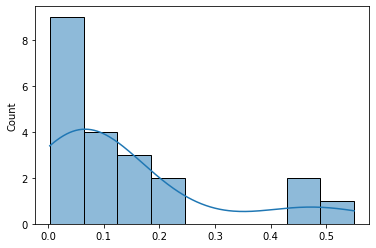

In [25]:
counts = dict((k, v) for k, v in bet_cen.items() if v > 0)

sns.histplot(counts, kde=True);

**Assortativity**

Assortivity is a measure of the tendency that nodes interact with similar nodes.

In this network the assortivity is -0.67, which is a moderate negative correlation
* This means that larger degree nodes tend to attach to smaller degree nodes
* There is not much structure

In [95]:
nx.degree_assortativity_coefficient(g)

-0.6682140067239859

**Removing smaller nodes**

By removing nodes with degrees smaller than 2 (this was the maximum that was able to be removed without the 'Found infinite path length because the graph is not connected' error), there appears to be 2 main and distinct hubs.

Also, the diameter decreases from 9 to 7.

In [96]:
g2 = g.copy()

remove = [node for node, degree in dict(g2.degree()).items() if degree < 2]
g2.remove_nodes_from(remove)

Diameter: 7


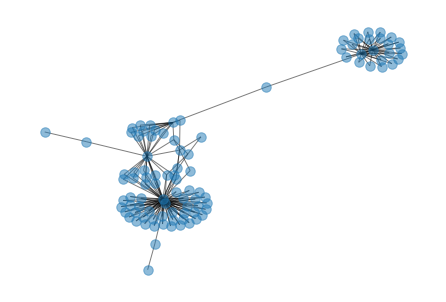

In [97]:
print('Diameter:', nx.diameter(g2))
layout = nx.spring_layout(g2)

nx.draw(g2,pos=layout,node_size=90,alpha=0.5)

**Comparing to random graphs**

Now we will generate 500 random graphs and compare to see how the social network is to average statistics.

In [22]:
n = g.number_of_nodes()
e = g.number_of_edges() 
p = e/(n*(n-1.0)/2.0) 

average_clust = []
average_assort = []
for i in range(500):
    graph = nx.erdos_renyi_graph(n,p)
    average_clust.append(nx.average_clustering(graph))
    average_assort.append(nx.degree_assortativity_coefficient(graph))

The social network has a higher clustering and lower assortativity than the average network, meaning our social network tends to cluster more than random graphs, and nodes will interact with dissimilar nodes more often.

In [26]:
print('mean clustering coefficient: ', sum(average_clust) / len(average_clust))
print('social network mean clustering coefficient: ', np.asarray(list(clust_c.values())).mean())

mean clustering coefficient:  0.0004613304593221492
social network mean clustering coefficient:  0.027247421431211827


In [27]:
print('mean assortativity: ', sum(average_assort) / len(average_assort))
print('social network assortativity: ', nx.degree_assortativity_coefficient(g))

mean assortativity:  0.00046681893971515674
social network assortativity:  -0.6682140067239859
